In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import random

np.random.seed(42)

In [2]:
import math

class ImagePlot:
    def __init__(self, max_columns=5):
        self.reset()
        self.max_columns = max_columns

    def reset(self):
        self.images = []

    def add(self, image, title=""):
        self.images.append({
            "image": image,
            "title": title
        })

    def show(self):
        n_rows = math.ceil(len(self.images) / self.max_columns)
        n_cols = self.max_columns

        plt.figure(figsize=(25, 7))
        for i in range(len(self.images)):
            plt.subplot(n_rows, n_cols, i+1)
            plt.imshow(self.images[i]["image"], cmap="gray")
            plt.title(self.images[i]["title"])
            plt.axis("off")

        plt.show()

plotter = ImagePlot()

In [3]:
data = scipy.io.loadmat("./data/MNIST.mat")
X = data["X"]
Y = data["I"]

In [4]:
print(X.shape)
print(Y.shape)

(256, 1707)
(1, 1707)


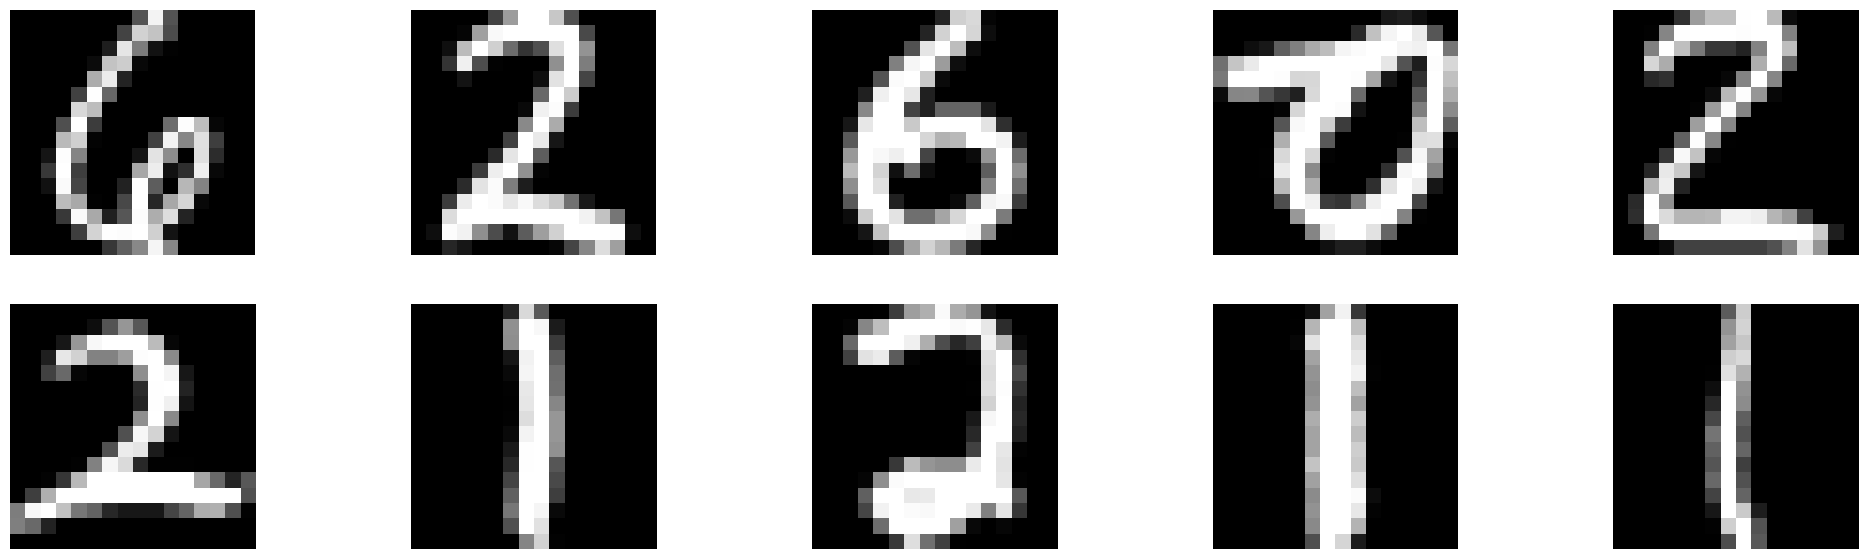

In [5]:
plotter.reset()

for i in [random.randint(0, X.shape[1]) for _ in range(10)]:
    plotter.add(X[:, i].reshape((16, 16)))

plotter.show()

In [6]:
def getImagesOfDigit(digit, X, Y):
    return X[:, (Y[0] == digit)]

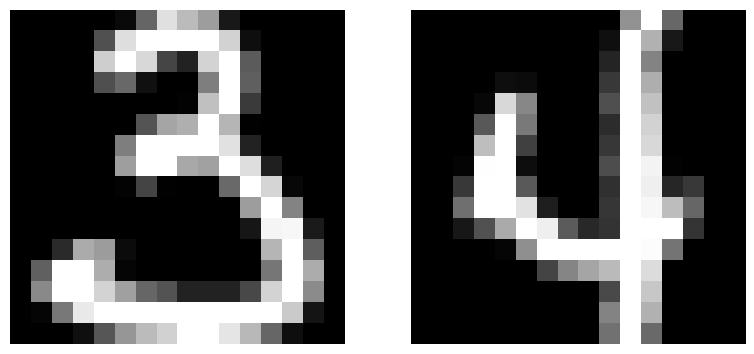

In [7]:
c1 = 3
c2 = 4
X_c1 = getImagesOfDigit(c1, X, Y)
X_c2 = getImagesOfDigit(c2, X, Y)

plotter.reset()
plotter.add(X_c1[:, 0].reshape((16, 16)))
plotter.add(X_c2[:, 0].reshape((16, 16)))
plotter.show()

In [8]:
def split_train_test(X, train_ratio):
    train_size = int(train_ratio * X.shape[1])
    idxs = np.arange(0, X.shape[1])
    np.random.shuffle(idxs)
    return X[:, idxs[:train_size]], X[:, idxs[train_size:]]

In [9]:
X_c1_train, X_c1_test = split_train_test(X_c1, 0.8)
X_c2_train, X_c2_test = split_train_test(X_c2, 0.8)

print(f"X_c1 | train: {X_c1_train.shape} -- test: {X_c1_test.shape}")
print(f"X_c2 | train: {X_c2_train.shape} -- test: {X_c2_test.shape}")

X_c1 | train: (256, 104) -- test: (256, 27)
X_c2 | train: (256, 97) -- test: (256, 25)


In [10]:
class MNISTBinaryClassPredict:
    def __init__(self):
        self.U1, self.c1 = None, None
        self.U2, self.c2 = None, None

    def fit(self, train_set_c1, label_c1, train_set_c2, label_c2):
        U1, _, _ = np.linalg.svd(train_set_c1, full_matrices=False)
        self.U1 = U1
        self.c1 = label_c1

        U2, _, _ = np.linalg.svd(train_set_c2, full_matrices=False)
        self.U2 = U2
        self.c2 = label_c2

    def predict(self, digit):
        y1_proj = self.U1 @ (self.U1.T @ digit)
        y2_proj = self.U2 @ (self.U2.T @ digit)

        dist1 = np.linalg.norm(digit - y1_proj, 2)
        dist2 = np.linalg.norm(digit - y2_proj, 2)

        if dist1 < dist2:
            return self.c1
        else:
            return self.c2


def evaluate(model, dataset, true_label):
    correct = 0
    for i in range(dataset.shape[1]):
        if model.predict(dataset[:, i]) == true_label:
            correct += 1
    return correct

In [16]:
def evaluateBinaryClass(c1, c2):
    X_c1 = getImagesOfDigit(c1, X, Y)
    X_c2 = getImagesOfDigit(c2, X, Y)
    X_c1_train, X_c1_test = split_train_test(X_c1, 0.7)
    X_c2_train, X_c2_test = split_train_test(X_c2, 0.7)


    model = MNISTBinaryClassPredict()
    model.fit(X_c1_train, c1, X_c2_train, c2)

    c1_correct = evaluate(model, X_c1_test, c1)
    c2_correct = evaluate(model, X_c2_test, c2)
    c1_test_size = X_c1_test.shape[1]
    c2_test_size = X_c2_test.shape[1]
    return c1_correct, c1_test_size, c2_correct, c2_test_size


c1_correct, c1_test_size, c2_correct, c2_test_size = evaluateBinaryClass(3, 4)
print(f"Accuracy ({c1}): {c1_correct / c1_test_size:.3f} ({c1_test_size-c1_correct}/{c1_test_size} wrong)")
print(f"Accuracy ({c2}): {c2_correct / c2_test_size:.3f} ({c2_test_size-c2_correct}/{c2_test_size} wrong)")

Accuracy (3): 1.000 (0/40 wrong)
Accuracy (4): 1.000 (0/37 wrong)


Minimum overall accuracy: 0.683


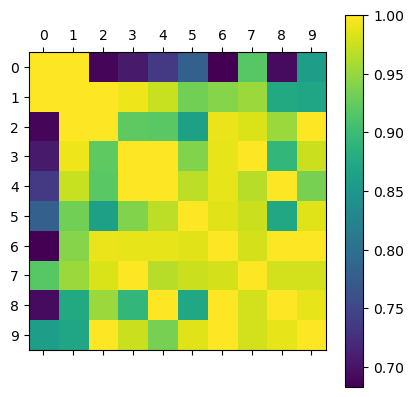

In [43]:
accuracies = np.zeros((10, 10))

for i in range(0, 10):
    for j in range(i, 10):
        c1_correct, c1_test_size, c2_correct, c2_test_size = evaluateBinaryClass(i, j)
        accuracy = (c1_correct + c2_correct) / (c1_test_size + c2_test_size)
        accuracies[i, j] = accuracies[j, i] = accuracy
        

print(f"Minimum overall accuracy: {np.min(accuracies):.3f}")

plt.matshow(accuracies)
plt.colorbar()
plt.xticks(range(0, 10))
plt.yticks(range(0, 10))
plt.show()

In [12]:
class MNISTMultiClassPredict:
    def __init__(self):
        self.U_n = {}

    def fit(self, digits_train_sets, digits_train_labels):
        for dataset, label in zip(digits_train_sets, digits_train_labels):
            U, _, _ = np.linalg.svd(dataset, full_matrices=False)
            self.U_n[label] = U

    def predict(self, digit):
        best_dist = +np.inf
        prediction = None

        for label in self.U_n:
            U = self.U_n[label]
            proj = U @ (U.T @ digit)

            dist = np.linalg.norm(digit - proj, 2)
            if dist < best_dist:
                best_dist = dist
                prediction = label

        return prediction

In [45]:
def evaluateMultiClass(classes):
    train_sets = []
    test_sets = []

    for digit in classes:
        train, test = split_train_test(X[:, (Y[0] == digit)], 0.7)
        train_sets.append(train)
        test_sets.append(test)

    model = MNISTMultiClassPredict()
    model.fit(train_sets, classes)

    out = []
    for label, test_set in zip(classes, test_sets):
        correct = evaluate(model, test_set, label)
        out.append((correct, test_set.shape[1]))

    return out

to_train_digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
class_res = evaluateMultiClass(to_train_digits)

for label, (correct, test_size) in zip(to_train_digits, class_res):
    print(f"{label} | Accuracy: {correct / test_size:.3f} ({test_size-correct}/{test_size} wrong)")

0 | Accuracy: 1.000 (0/96 wrong)
1 | Accuracy: 1.000 (0/76 wrong)
2 | Accuracy: 0.328 (41/61 wrong)
3 | Accuracy: 0.000 (40/40 wrong)
4 | Accuracy: 0.054 (35/37 wrong)
5 | Accuracy: 0.000 (27/27 wrong)
6 | Accuracy: 0.000 (46/46 wrong)
7 | Accuracy: 0.680 (16/50 wrong)
8 | Accuracy: 0.023 (43/44 wrong)
9 | Accuracy: 0.275 (29/40 wrong)


In [77]:
accuracies = {}

for i in range(0, 10):
    for j in range(i+1, 10):
        for k in range(j+1, 10):
            if len(set([i, j, k])) == 2: continue

            class_res = evaluateMultiClass([i, j, k])
            accuracy = (class_res[0][0] + class_res[1][0] + class_res[2][0]) / (class_res[0][1] + class_res[1][1] + class_res[2][1])
            accuracies[tuple(sorted([i, j, k]))] = accuracy

best_config = max(accuracies, key=accuracies.get)
worst_config = min(accuracies, key=accuracies.get)
print(f" Best: {best_config} ({accuracies[best_config]})")
print(f"Worst: {worst_config} ({accuracies[worst_config]})")

 Best: (3, 6, 7) (1.0)
Worst: (0, 3, 8) (0.5333333333333333)
